In [2]:
import geopandas as gpd
import pandas as pd
from pycaret.classification import *
import matplotlib.pyplot as plt 
import numpy as np
# for korean plotting
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
import os
os.chdir('/Users/dangchan/Desktop/Github/LocalSecurity_competition')

In [3]:
# Load files : grid, kderesult, census data
grid = gpd.read_file('data/CENSUS/grid_DJ_100M.gpkg')
density = pd.read_csv('STKDE/result/DJ_100M_sb_700_tb_25.csv')
census = gpd.read_file('df_full_100M.gpkg').fillna(0)

result_grid = density.groupby(['X','Y'], as_index=False).sum()
result_grid = gpd.GeoDataFrame(result_grid['density'], geometry=gpd.points_from_xy(result_grid.X, result_grid.Y), crs='epsg:5181')

# 격자에 병합
grid = grid.sjoin(result_grid, how='left')
grid = grid[grid.columns.drop('index_right')]
# grid.density = (grid.density - grid.density.mean()) / grid.density.std() # normalize target density

# census data
df = grid.set_index('GRID_100M_').join(census[census.columns.drop('geometry')].set_index('GRID_100M_')).reset_index(drop=True)
df = df[df.columns.drop('geometry')]

In [4]:
# Target density to Hotspot 
df['Hotspot'] = df.density >= df.density.quantile(0.8)
df = df[df.columns.drop('density')]

In [5]:
clf = setup(
    data=df, target="Hotspot", session_id=123,
    transformation=True, normalize=True, numeric_imputation='mode',
    remove_multicollinearity=True, multicollinearity_threshold=0.95,
)

,Description,Value
0,Session id,123
1,Target,Hotspot
2,Target type,Binary
3,Original data shape,"(54910, 15)"
4,Transformed data shape,"(54910, 13)"
5,Transformed train set shape,"(38436, 13)"
6,Transformed test set shape,"(16474, 13)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


In [6]:
clf.compare_models(errors='raise')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9037,0.8289,0.6027,0.8775,0.7144,0.6589,0.6758,0.3420
lightgbm,Light Gradient Boosting Machine,0.9036,0.8285,0.5970,0.8834,0.7122,0.6570,0.6753,0.1450
xgboost,Extreme Gradient Boosting,0.9033,0.8286,0.5952,0.8835,0.7110,0.6556,0.6742,0.8290
knn,K Neighbors Classifier,0.9016,0.8207,0.5957,0.8717,0.7074,0.6508,0.6680,1.6440
ada,Ada Boost Classifier,0.9016,0.8276,0.5819,0.8875,0.7027,0.6468,0.6676,0.2050
rf,Random Forest Classifier,0.9011,0.8247,0.5819,0.8845,0.7016,0.6454,0.6659,0.3100
et,Extra Trees Classifier,0.8986,0.8145,0.5643,0.8885,0.6899,0.6330,0.6564,0.2740
dt,Decision Tree Classifier,0.8931,0.7724,0.5340,0.8871,0.6665,0.6075,0.6354,0.0410
lr,Logistic Regression,0.8918,0.8264,0.5645,0.8426,0.6758,0.6139,0.6318,0.6620
ridge,Ridge Classifier,0.8918,0.0000,0.5541,0.8539,0.6718,0.6106,0.6312,0.0440


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [7]:
gbc = clf.create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9004,0.8281,0.5995,0.8601,0.7065,0.6488,0.6641
1,0.9011,0.8151,0.5813,0.8851,0.7017,0.6455,0.6660
2,0.9079,0.8382,0.6268,0.8780,0.7314,0.6777,0.6917
3,0.9030,0.8284,0.5930,0.8837,0.7097,0.6542,0.6729
4,0.9045,0.8347,0.6164,0.8681,0.7209,0.6653,0.6795
5,0.8988,0.8163,0.5735,0.8785,0.6939,0.6365,0.6573
6,0.9027,0.8222,0.5898,0.8848,0.7078,0.6522,0.6715
7,0.9042,0.8287,0.5964,0.8876,0.7134,0.6586,0.6773
8,0.9061,0.8399,0.6224,0.8707,0.7259,0.6711,0.6849


In [9]:
tuned_gbc = tune_model(gbc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8985,0.8280,0.5670,0.8844,0.6910,0.6337,0.6561
1,0.8998,0.8152,0.5605,0.9017,0.6913,0.6353,0.6609
2,0.9089,0.8381,0.6060,0.9084,0.7270,0.6749,0.6949
3,0.9006,0.8283,0.5644,0.9023,0.6944,0.6388,0.6639
4,0.9071,0.8347,0.6008,0.9023,0.7213,0.6683,0.6882
5,0.8972,0.8161,0.5527,0.8929,0.6827,0.6254,0.6511
6,0.9019,0.8225,0.5638,0.9116,0.6967,0.6420,0.6684
7,0.9024,0.8285,0.5742,0.9018,0.7017,0.6467,0.6703
8,0.9032,0.8401,0.5964,0.8808,0.7112,0.6556,0.6736


In [10]:
plot_model(tuned_gbc, plot='parameter')

,Parameters
ccp_alpha,0.0
criterion,friedman_mse
init,None
learning_rate,0.1
loss,log_loss
max_depth,3
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_samples_leaf,1


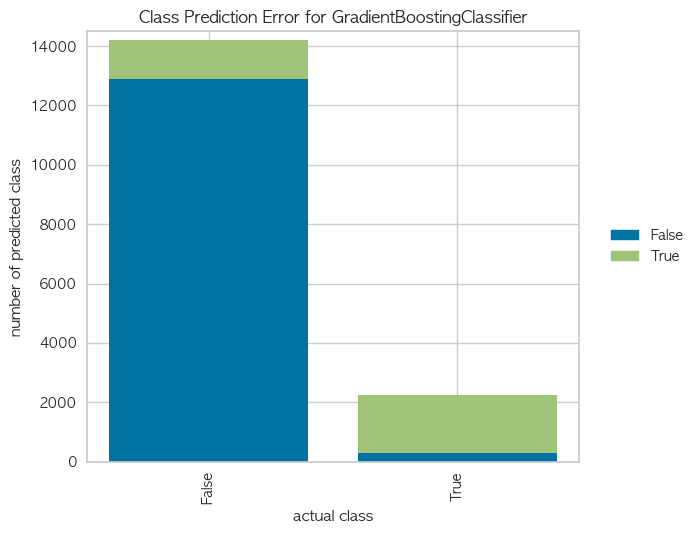

In [11]:
plot_model(tuned_gbc, 'error')

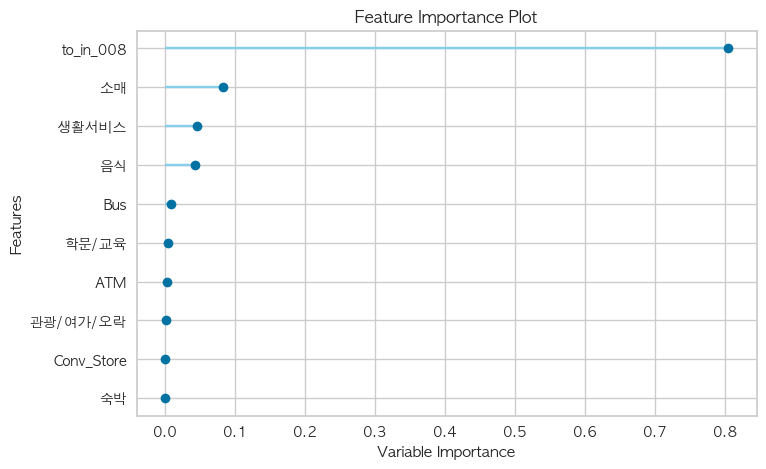

In [12]:
plot_model(tuned_gbc, 'feature')

## Prediction

In [17]:
# Load files : grid, kderesult, census data
grid_SJ = gpd.read_file('data/CENSUS/grid_SJ_100M.gpkg')
census = gpd.read_file('df_full_100M.gpkg').fillna(0)

# census data
df_predict = grid.set_index('GRID_100M_').join(census[census.columns.drop('geometry')].set_index('GRID_100M_')).reset_index(drop=True)
df_predict = df_predict[df_predict.columns.drop('geometry')]

In [18]:
df_predict = predict_model(tuned_gbc, data=df_predict)

In [22]:
df_predict.prediction_label.value_counts()

0    47373
1     7537
Name: prediction_label, dtype: int64

In [23]:
grid_SJ['Hotspot'] = df_predict['prediction_label']

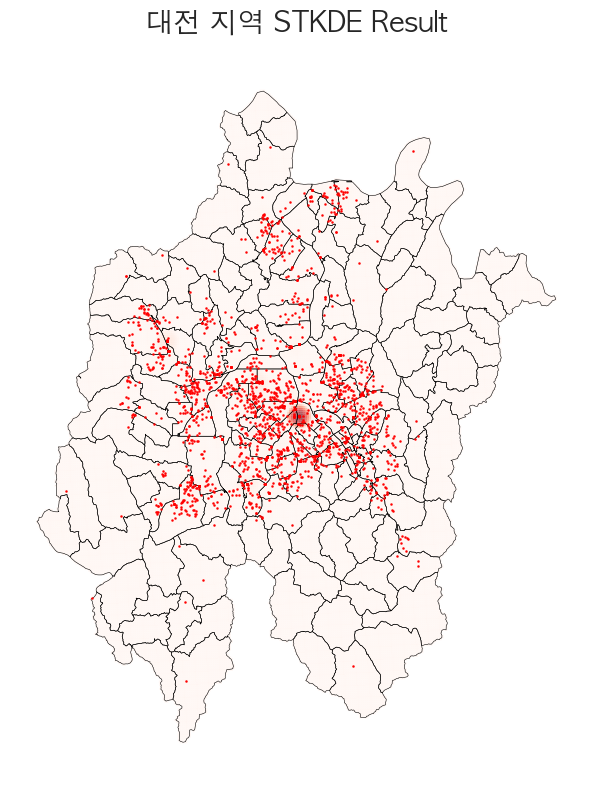

In [28]:
daejeon = gpd.read_file('data/ADM_AREA/대전/LSMD_ADM_SECT_UMD_30.shp', encoding='cp949').to_crs(epsg=5181)
crime_daejeon = gpd.read_file('data/gdf_crime_adm_DJ.gpkg').to_crs(epsg=5181)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
daejeon.boundary.plot(ax=ax, zorder=2, color='black', linewidth = 0.4)
grid.plot(column = 'density',ax=ax, zorder=1, cmap='Reds', alpha=0.7)
crime_daejeon.geometry.plot(ax=ax, zorder=3, color='red', markersize=2)

ax.set_axis_off()

plt.suptitle('대전 지역 STKDE Result', fontsize=20)
plt.tight_layout()
plt.show()

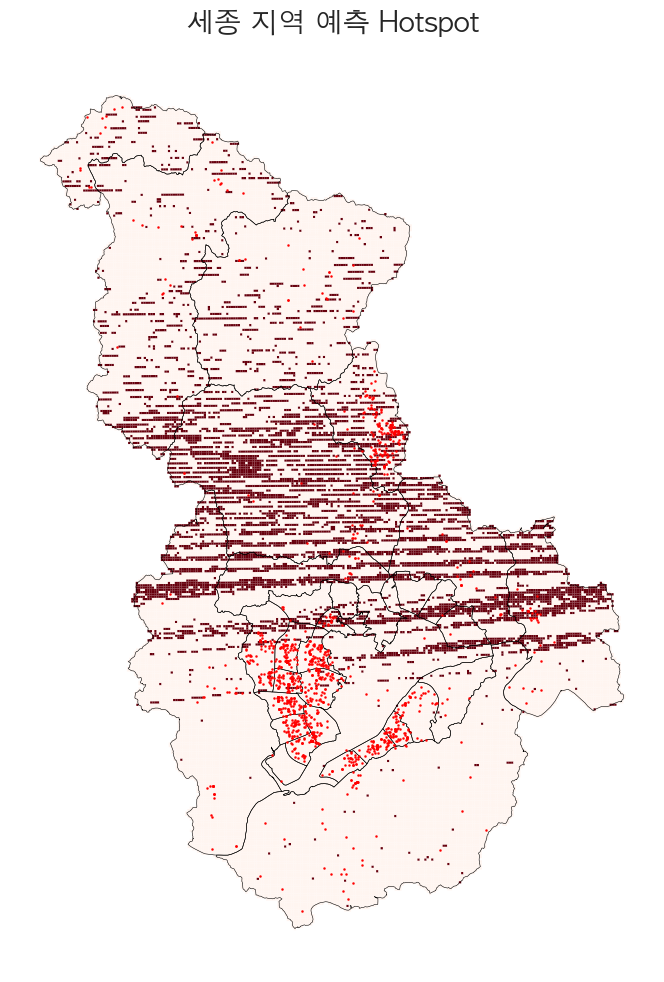

In [29]:
# Prediction map
sejong = gpd.read_file('data/ADM_AREA/세종/LSMD_ADM_SECT_UMD_36.shp', encoding='cp949').to_crs(epsg=5181)
crime_sejong = gpd.read_file('data/gdf_crime_adm_SJ.gpkg')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10))
sejong.boundary.plot(ax=ax, zorder=2, color='black', linewidth = 0.4)
grid_SJ.plot(column = 'Hotspot',ax=ax, zorder=1, cmap='Reds')
crime_sejong.geometry.plot(ax=ax, zorder=3, color='red', markersize=2)

ax.set_axis_off()

plt.suptitle('세종 지역 예측 Hotspot', fontsize=20)
plt.tight_layout()
plt.show()